# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [146]:
# Import your libraries:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [237]:
pd.set_option('display.max_columns', 20)
websites = pd.read_csv('../data/website.csv')

#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

In [238]:
# Your code here
websites.head(10)

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0
5,B0_2064,18,7,UTF-8,nginx,NaN,SC,Mahe,3/08/2016 14:30,3/10/2016 3:45,...,6,9,894,11,13,838,894,11,0.0,0
6,B0_462,18,6,iso-8859-1,Apache/2,345.0,US,CO,29/07/2002 0:00,1/07/2016 0:00,...,0,3,1189,14,13,8559,1327,14,2.0,0
7,B0_1128,19,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,US,FL,18/03/1997 0:00,19/03/2017 0:00,...,0,0,0,0,0,0,0,0,0.0,0
8,M2_17,20,5,utf-8,nginx/1.10.1,NaN,None,None,8/11/2014 7:41,None,...,0,0,0,2,3,213,146,2,2.0,1
9,M3_75,20,5,utf-8,nginx/1.10.1,NaN,None,None,8/11/2014 7:41,None,...,0,0,0,2,1,62,146,2,2.0,1


In [239]:
websites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        1781 non-null   object 
 1   URL_LENGTH                 1781 non-null   int64  
 2   NUMBER_SPECIAL_CHARACTERS  1781 non-null   int64  
 3   CHARSET                    1781 non-null   object 
 4   SERVER                     1780 non-null   object 
 5   CONTENT_LENGTH             969 non-null    float64
 6   WHOIS_COUNTRY              1781 non-null   object 
 7   WHOIS_STATEPRO             1781 non-null   object 
 8   WHOIS_REGDATE              1781 non-null   object 
 9   WHOIS_UPDATED_DATE         1781 non-null   object 
 10  TCP_CONVERSATION_EXCHANGE  1781 non-null   int64  
 11  DIST_REMOTE_TCP_PORT       1781 non-null   int64  
 12  REMOTE_IPS                 1781 non-null   int64  
 13  APP_BYTES                  1781 non-null   int64

In [240]:
# Your comment here
websites.describe()    

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
count,1781.000000,1781.000000,969.000000,1781.000000,1781.000000,1781.000000,1.781000e+03,1781.000000,1781.000000,1.781000e+03,1.781000e+03,1781.000000,1780.000000,1781.000000
mean,56.961258,11.111735,11726.927761,16.261089,5.472768,3.060640,2.982339e+03,18.540146,18.746210,1.589255e+04,3.155599e+03,18.540146,2.263483,0.121280
std,27.555586,4.549896,36391.809051,40.500975,21.807327,3.386975,5.605057e+04,41.627173,46.397969,6.986193e+04,5.605378e+04,41.627173,2.930853,0.326544
min,16.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,39.000000,8.000000,324.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
50%,49.000000,10.000000,1853.000000,7.000000,0.000000,2.000000,6.720000e+02,8.000000,9.000000,5.790000e+02,7.350000e+02,8.000000,0.000000,0.000000
75%,68.000000,13.000000,11323.000000,22.000000,5.000000,5.000000,2.328000e+03,26.000000,25.000000,9.806000e+03,2.701000e+03,26.000000,4.000000,0.000000
max,249.000000,43.000000,649263.000000,1194.000000,708.000000,17.000000,2.362906e+06,1198.000000,1284.000000,2.060012e+06,2.362906e+06,1198.000000,20.000000,1.000000


#### Next, evaluate if the columns in this dataset are strongly correlated.

If our dataset has strongly correlated columns, we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

C:\Users\udaya\AppData\Local\Temp\ipykernel_13420\2293731283.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


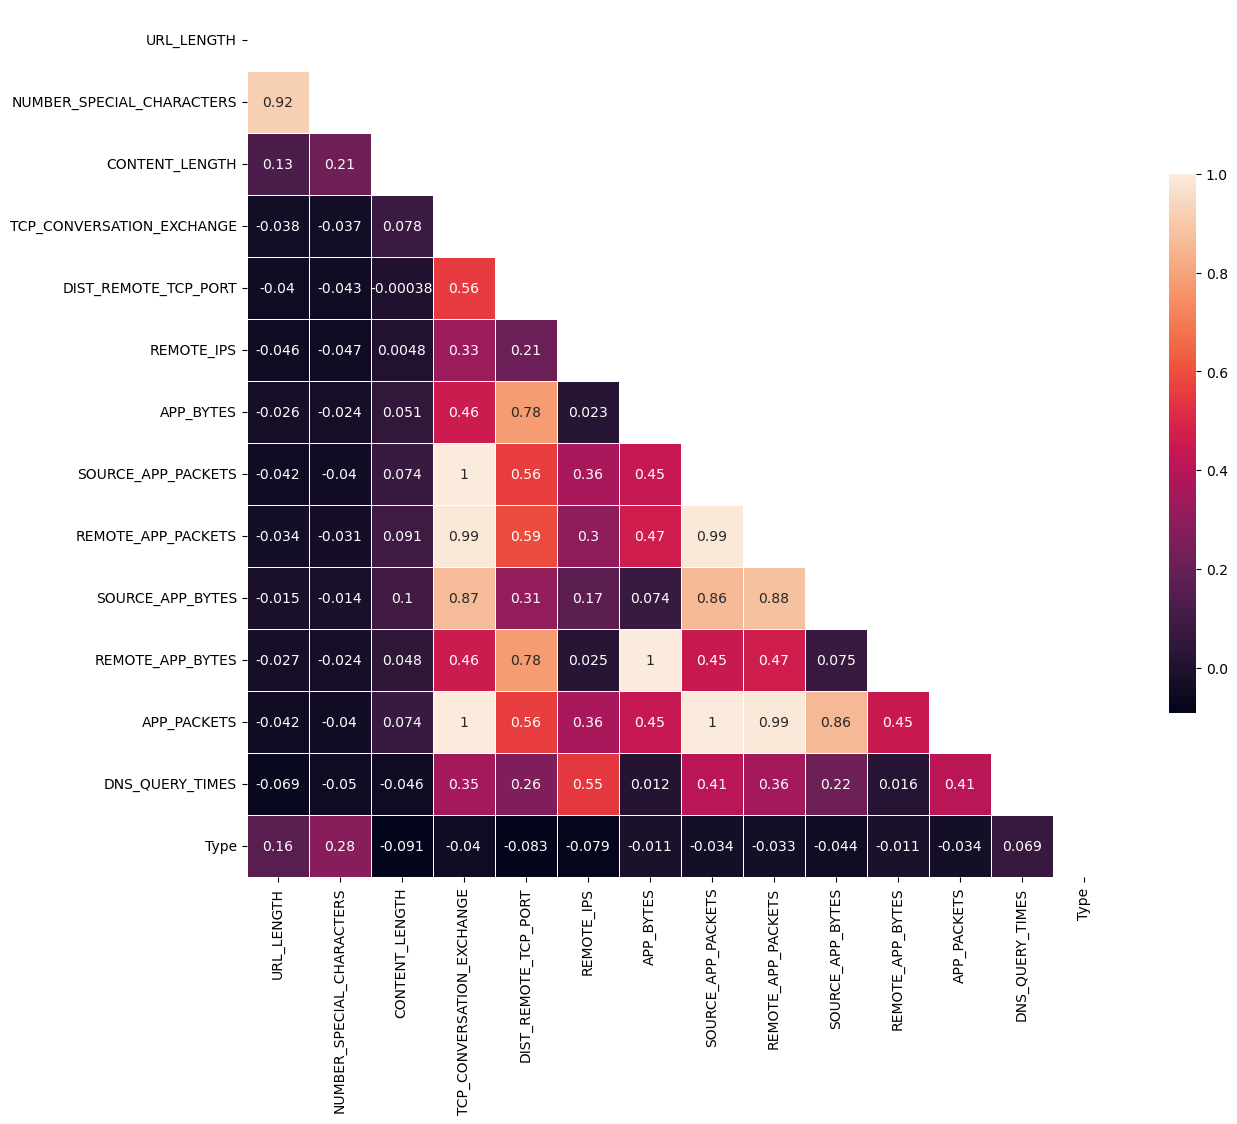

In [241]:
# Your code here
corr = websites.corr()

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 14))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

In [242]:
# Your comment here
col_to_keep = ["NUMBER_SPECIAL_CHARACTERS", "CONTENT_LENGTH", "TCP_CONVERSATION_EXCHANGE", "REMOTE_IPS", "APPS_BYTES"]
col_to_drop = ["URL_LENGTH", "APP_PACKETS", "SOURCE_APP_BYTES", "REMOTE_APP_PACKETS", "SOURCE_APP_PACKETS", "DIST_REMOTE_TCP_PORT", "DNS_QUERY_TIMES", "REMOTE_APP_BYTES"]

In [243]:
# While doing collinearity check, i tried to avoid features that are highly correlated with each other.
# So first strategy is to pick one feature which is "NUMBER_SPECIAL_CHARACTERS",
# followed by other features which are not highly correlated with each other irrespective of collinearity with target. 

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

C:\Users\udaya\AppData\Local\Temp\ipykernel_13420\81179241.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


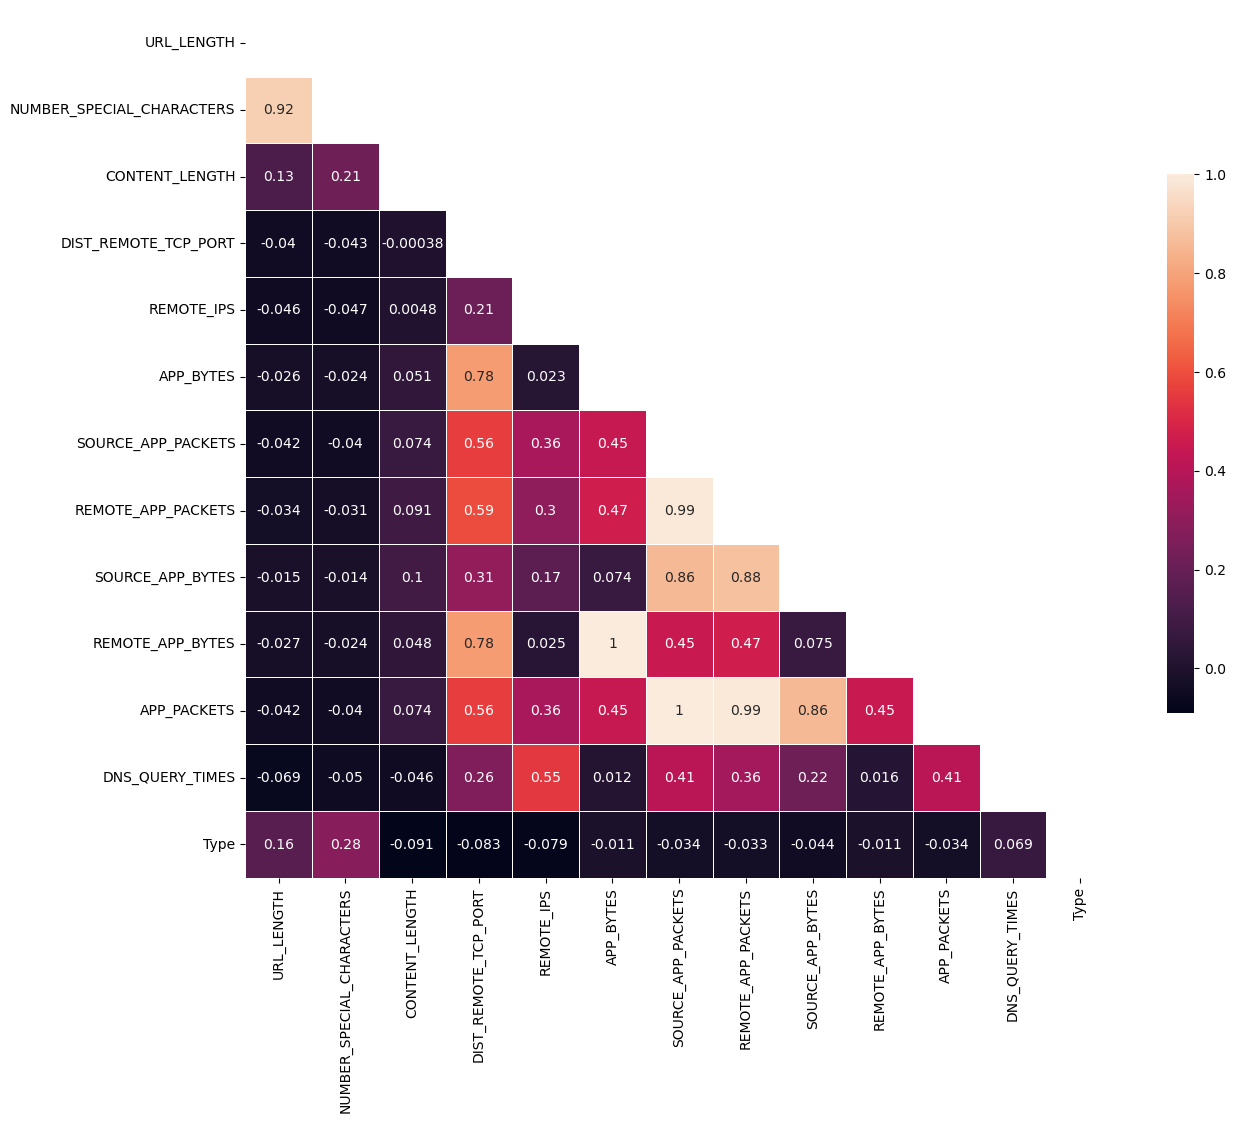

In [281]:
# Your code here
# Your code here
remove_1 = websites.loc[:, websites. columns != "TCP_CONVERSATION_EXCHANGE"]
corr = remove_1.corr()

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 14))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

C:\Users\udaya\AppData\Local\Temp\ipykernel_13420\2034950801.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


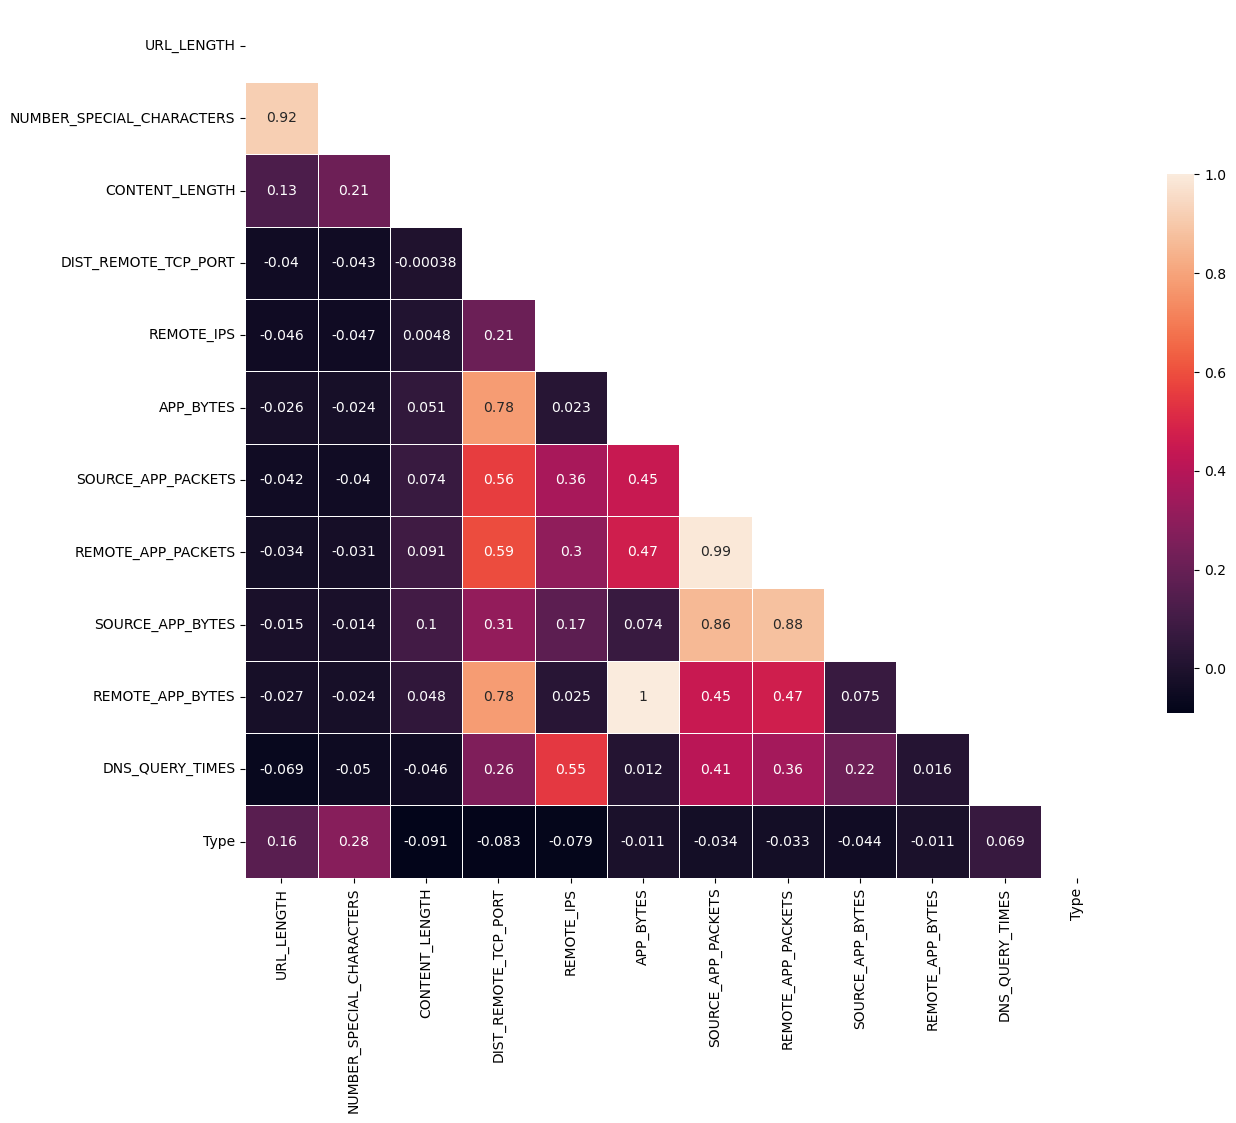

In [282]:
# Your comment here
remove_2 = remove_1.loc[:, remove_1. columns != "APP_PACKETS"]
corr = remove_2.corr()

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 14))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

C:\Users\udaya\AppData\Local\Temp\ipykernel_13420\466142181.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


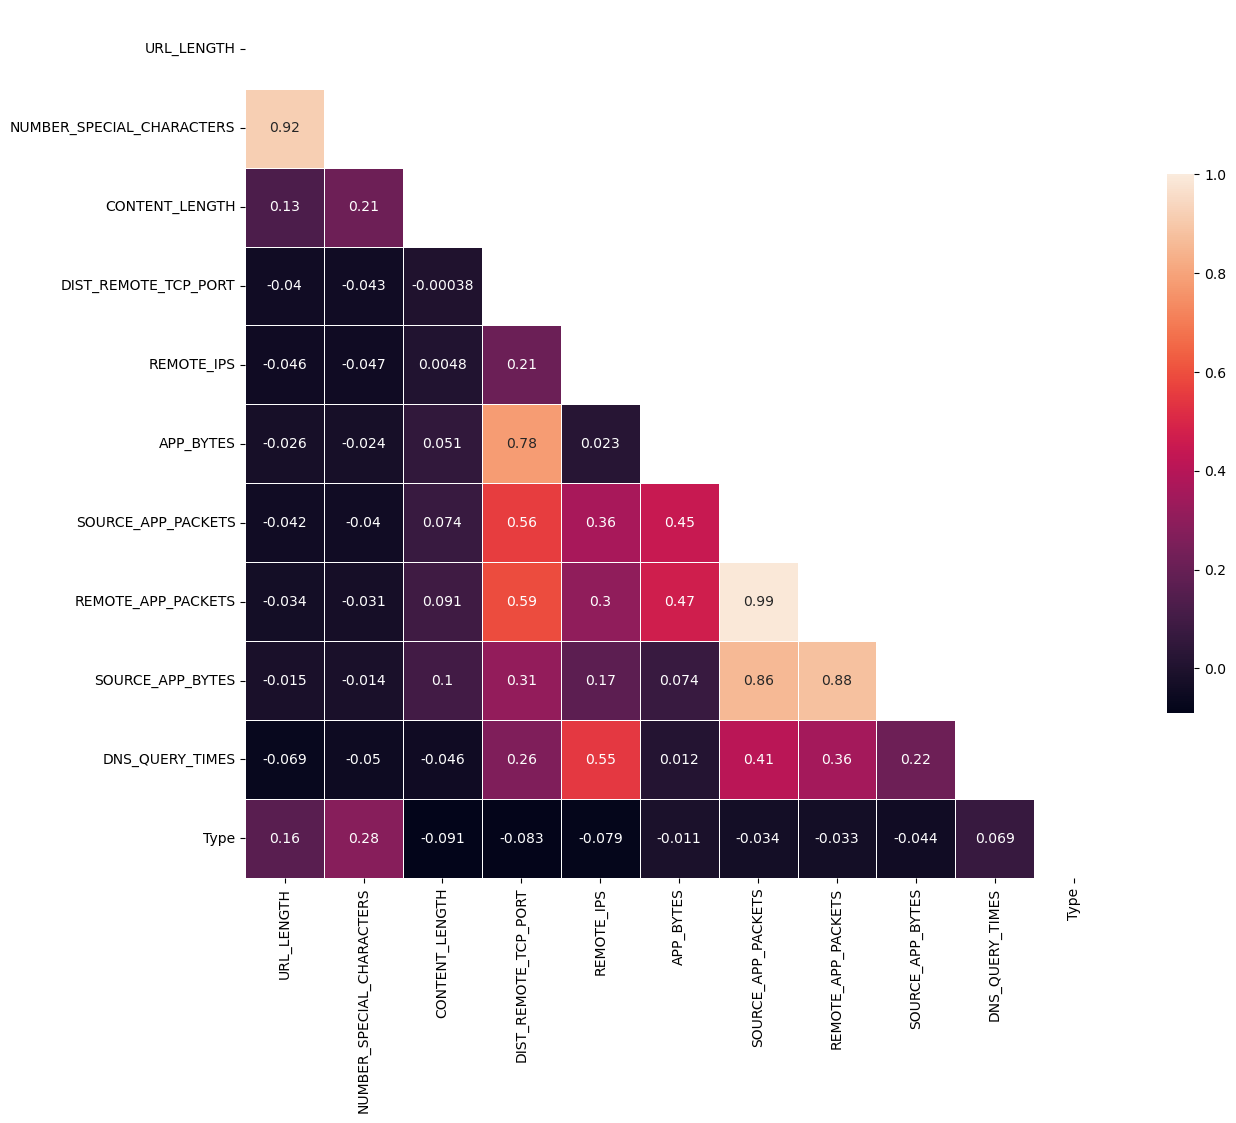

In [283]:
# Print heatmap again
remove_3 = remove_2.loc[:, remove_2. columns != "REMOTE_APP_BYTES"]
corr = remove_3.corr()

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 14))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

C:\Users\udaya\AppData\Local\Temp\ipykernel_13420\2487699723.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


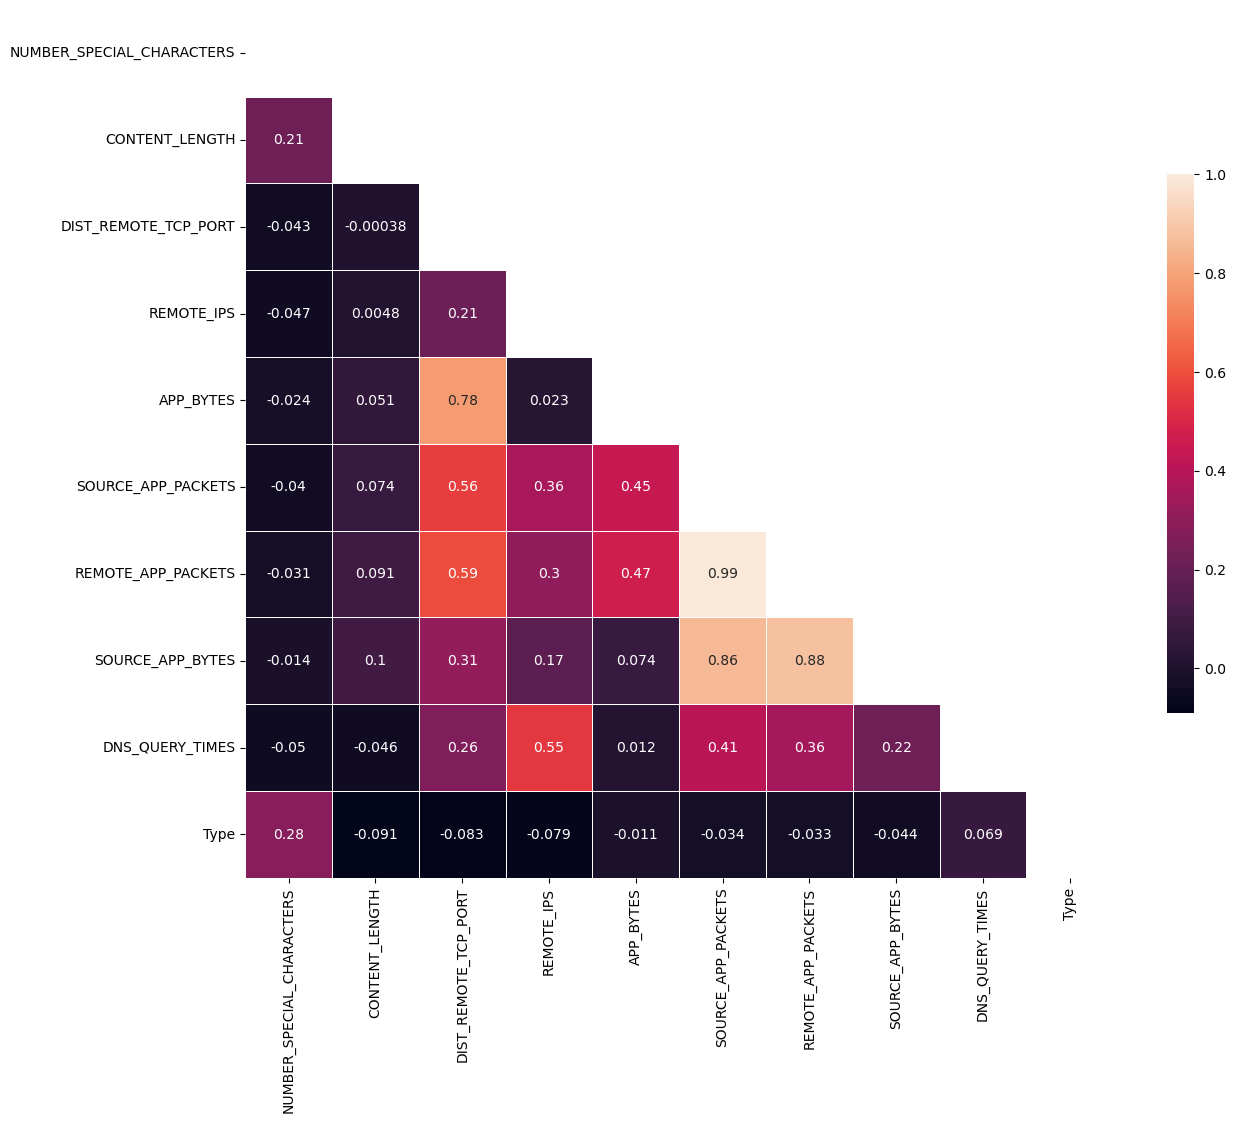

In [342]:
# Print heatmap again
remove_4 = remove_3.loc[:, remove_3. columns != "URL_LENGTH"]
corr = remove_4.corr()

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 14))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

C:\Users\udaya\AppData\Local\Temp\ipykernel_13420\1000905303.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


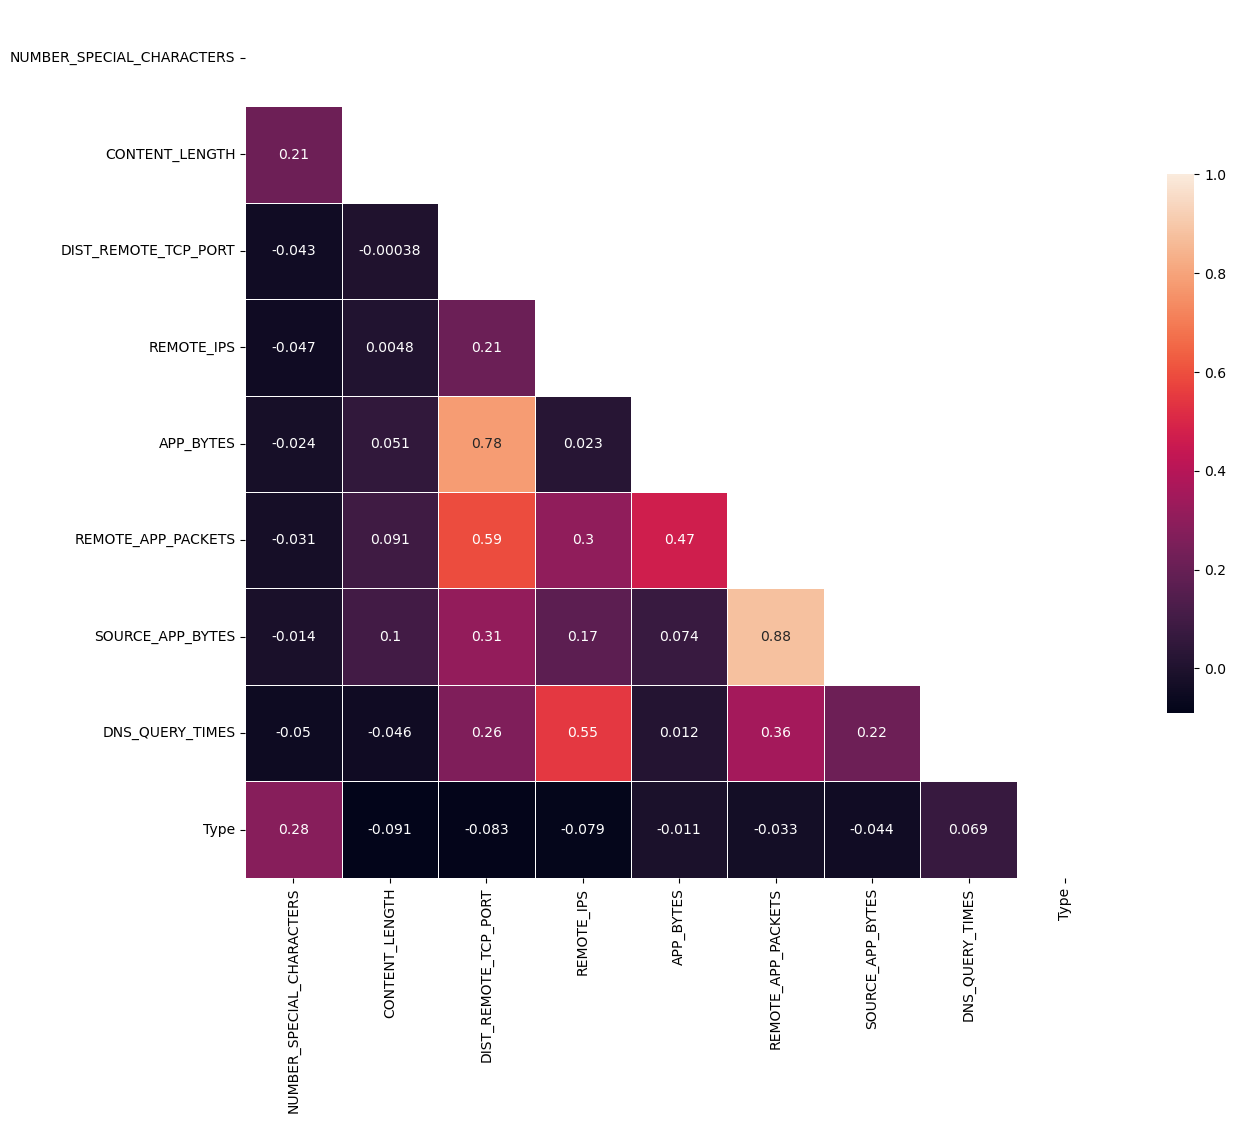

In [380]:
# Print heatmap again
remove_5 = remove_4.loc[:, remove_4. columns != "SOURCE_APP_PACKETS"]
corr = remove_5.corr()

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 14))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

In [381]:
remove_5.head()

,URL,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,DNS_QUERY_TIMES,Type
0,M0_109,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,0,2,700,10,1153,2.0,1
1,B0_2314,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,7,4,1230,19,1265,0.0,0
2,B0_911,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,0,0,0,0,0,0.0,0
3,B0_113,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,22,3,3812,37,18784,8.0,0
4,B0_403,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,2,5,4278,62,129889,4.0,0


# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [382]:
# Your code here
print(remove_5.isnull().sum())
remove_5.info()

URL                            0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        0
SERVER                         1
CONTENT_LENGTH               812
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
WHOIS_REGDATE                  0
WHOIS_UPDATED_DATE             0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        1781 non-null   object 
 1   NUMBER_SPECIAL_CHARACTERS  1781 non-null   int64  
 2   CHARSET                    1781 non-null   object 
 3   SERVER                     1780 non-null   object 
 4   CONTENT_LEN

If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [383]:
# Your code here
remove_5.drop(columns = ["CONTENT_LENGTH"], inplace = True)
remove_5 = remove_5.dropna()

C:\Users\udaya\AppData\Local\Temp\ipykernel_13420\3791244846.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_5.drop(columns = ["CONTENT_LENGTH"], inplace = True)


In [384]:
remove_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1779 entries, 0 to 1780
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        1779 non-null   object 
 1   NUMBER_SPECIAL_CHARACTERS  1779 non-null   int64  
 2   CHARSET                    1779 non-null   object 
 3   SERVER                     1779 non-null   object 
 4   WHOIS_COUNTRY              1779 non-null   object 
 5   WHOIS_STATEPRO             1779 non-null   object 
 6   WHOIS_REGDATE              1779 non-null   object 
 7   WHOIS_UPDATED_DATE         1779 non-null   object 
 8   DIST_REMOTE_TCP_PORT       1779 non-null   int64  
 9   REMOTE_IPS                 1779 non-null   int64  
 10  APP_BYTES                  1779 non-null   int64  
 11  REMOTE_APP_PACKETS         1779 non-null   int64  
 12  SOURCE_APP_BYTES           1779 non-null   int64  
 13  DNS_QUERY_TIMES            1779 non-null   float

In [385]:
# Your comment here
# for content_length, there is almost 50% data point we are missing. so i decide not to use this column for this model. 
# for DNS_QUERY_TIMES, and SERVER has one missing value in each, so if the row is dropped that will be the fraction of our data that 
# we are going to loss. So, in this model i dropped both row. 

#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [386]:
# Examine missing values in each column


# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [387]:
# Your code here
def country_code(code):
    if code == "Cyprus":
        return "CY"
    elif code == "us":
        return "US"
    elif code == "se":
        return "SE"
    elif code == "ru":
        return "RU"
    elif code == "United Kingdom" or code == "[u'GB'; u'UK']" or code == "UK":
        return "GB"
    else:
        return code
    
remove_5['WHOIS_COUNTRY'] = remove_5['WHOIS_COUNTRY'].apply(country_code)


In [388]:
remove_5.WHOIS_COUNTRY.unique()

array(['None', 'US', 'OTHER', 'GB', 'AU', 'CA', 'PA', 'IN', 'JP', 'CN',
       'ES'], dtype=object)

Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

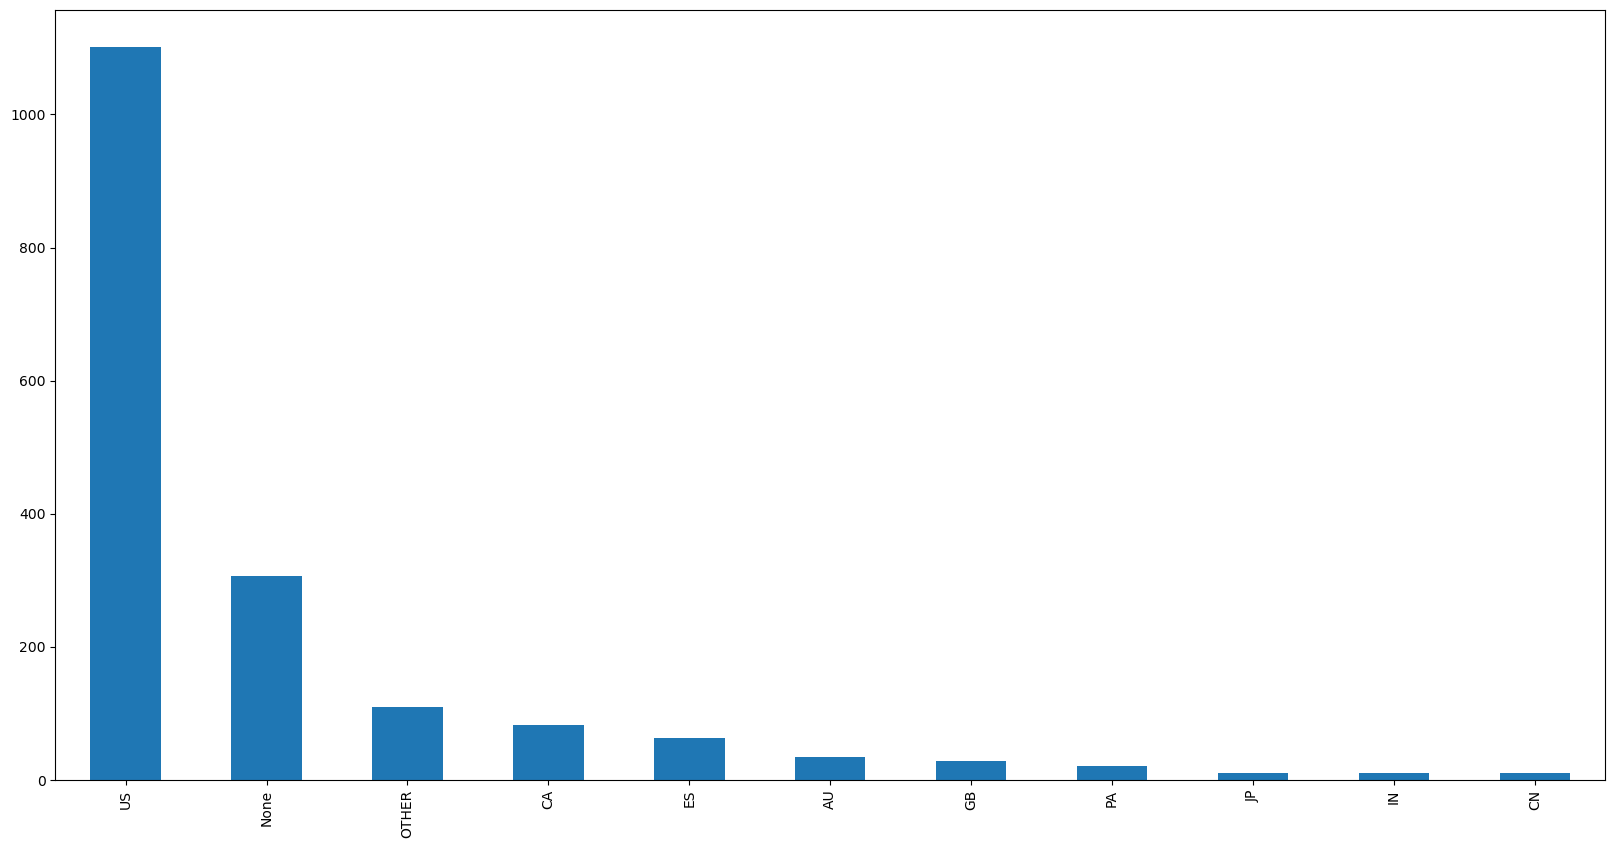

In [389]:
# Your code here
plt.figure(figsize = (20,10))
remove_5[['WHOIS_COUNTRY']].value_counts()
remove_5['WHOIS_COUNTRY'].value_counts().plot(kind='bar')
plt.show()

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [390]:
# Your code here
top_countries = remove_5['WHOIS_COUNTRY'].value_counts().head(11).index.tolist()
remove_5['WHOIS_COUNTRY'] = remove_5['WHOIS_COUNTRY'].apply(lambda x: x if x in top_countries else 'OTHER')

remove_5['WHOIS_COUNTRY'].value_counts()

US       1102
None      306
OTHER     109
CA         83
ES         63
AU         35
GB         29
PA         21
JP         11
IN         10
CN         10
Name: WHOIS_COUNTRY, dtype: int64

Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [391]:
# Your code here
remove_5.drop(columns = ['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'], inplace = True)

# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [392]:
# Your code here
remove_5.dtypes

URL                           object
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
WHOIS_COUNTRY                 object
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object

#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [393]:
# Your code here
remove_5.drop(columns = "URL", inplace = True)

#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [430]:
# Your code here
remove_5.CHARSET.unique()
remove_5.drop(columns = "CHARSET", inplace = True)

`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [431]:
# Your code here
remove_5.SERVER.unique()

array(['nginx', 'Other', 'Microsoft'], dtype=object)

![Think Hard](../images/think-hard.jpg)

In [432]:
# Your comment here
# There are one common thing we can find on server is the provider. So, one solutions will be to take first string-set (in this case the name of server provider)

Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [433]:
# Your code here
list_server = ["Apache", "nginx", "Microsoft"]
def replace_server(name):
    if "Microsoft" in name:
        return "Microsoft"
    elif "Apache" in name:
        return "Apacha"
    elif "nginx" in name:
        return "nginx"
    else:
        return "Other"

remove_5.SERVER = remove_5.SERVER.apply(replace_server)

In [434]:
# Count `SERVER` value counts here
remove_5.SERVER.value_counts()

Other        1146
nginx         435
Microsoft     198
Name: SERVER, dtype: int64

OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)). Also, assign the data with dummy values to a new variable `website_dummy`.**

In [435]:
# Your code here
website_dummy = pd.get_dummies(remove_5.SERVER)
website_dummy

,Microsoft,Other,nginx
0,0,0,1
1,0,1,0
2,1,0,0
3,0,0,1
4,0,1,0
...,...,...,...
1776,0,1,0
1777,0,1,0
1778,0,1,0
1779,0,0,1


Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [436]:
# Your code here
website_dummy.dtypes

Microsoft    uint8
Other        uint8
nginx        uint8
dtype: object

In [437]:
website_countries = pd.get_dummies(remove_5['WHOIS_COUNTRY'])
website_countries.head()

,AU,CA,CN,ES,GB,IN,JP,None,OTHER,PA,US
0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1


In [438]:
websites=remove_5.join(website_dummy)

In [439]:
websites = websites.join(website_countries)

In [440]:
websites.shape

(1779, 24)

In [441]:
websites.drop(['WHOIS_COUNTRY'],axis=1,inplace=True)
websites.drop(["SERVER"],axis=1, inplace=True)


In [442]:
websites.dtypes

NUMBER_SPECIAL_CHARACTERS      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
DNS_QUERY_TIMES              float64
Type                           int64
Microsoft                      uint8
Other                          uint8
nginx                          uint8
AU                             uint8
CA                             uint8
CN                             uint8
ES                             uint8
GB                             uint8
IN                             uint8
JP                             uint8
None                           uint8
OTHER                          uint8
PA                             uint8
US                             uint8
dtype: object

# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [443]:
from sklearn.model_selection import train_test_split

# Your code here:
features = websites.drop(["Type"],axis=1)
target = websites["Type"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size= 0.20, random_state = 0)

#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [444]:
# Your code here:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()


Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [445]:
# Your code here:
model.fit(X_train, y_train)


C:\Users\udaya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [447]:
# Your code here:
from sklearn.metrics import classification_report, confusion_matrix

pred = model.predict(X_test)
print(classification_report(y_test,pred))
confusion_matrix(y_test,pred)


              precision    recall  f1-score   support

           0       0.91      0.98      0.94       317
           1       0.57      0.21      0.30        39

    accuracy                           0.90       356
   macro avg       0.74      0.59      0.62       356
weighted avg       0.87      0.90      0.87       356



array([[311,   6],
       [ 31,   8]], dtype=int64)

What are your thoughts on the performance of the model? Write your conclusions below.

In [33]:
# Your conclusions here:



#### Our second algorithm is is K-Nearest Neighbors. 

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `KNeighborsClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where k=3.

In [448]:
# Your code here:

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors =3)
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=3)

To test your model, compute the predicted values for the testing sample and print the confusion matrix as well as the accuracy score.

In [449]:
# Your code here:

knn.fit(X_train, y_train)

#score
print("test data accuracy is", knn.score(X_test, y_test))
print("Train data accuracy is ", knn.score(X_train, y_train))

print(classification_report(y_test,pred))
confusion_matrix(y_test,pred)



test data accuracy is 0.9297752808988764
Train data accuracy is  0.9571328179901616
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       317
           1       0.57      0.21      0.30        39

    accuracy                           0.90       356
   macro avg       0.74      0.59      0.62       356
weighted avg       0.87      0.90      0.87       356



C:\Users\udaya\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\udaya\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

array([[311,   6],
       [ 31,   8]], dtype=int64)

#### We'll create another K-Nearest Neighbors model with k=5. 

Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [450]:
# Your code here:

knn = KNeighborsClassifier(n_neighbors =5)
knn.fit(X_train, y_train)
print("test data accuracy is", knn.score(X_test, y_test))
print("Train data accuracy is ", knn.score(X_train, y_train))

print(classification_report(y_test,pred))
confusion_matrix(y_test,pred)

test data accuracy is 0.9382022471910112
Train data accuracy is  0.9479971890372453
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       317
           1       0.57      0.21      0.30        39

    accuracy                           0.90       356
   macro avg       0.74      0.59      0.62       356
weighted avg       0.87      0.90      0.87       356



C:\Users\udaya\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\udaya\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

array([[311,   6],
       [ 31,   8]], dtype=int64)

Did you see an improvement in the confusion matrix when increasing k to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

In [37]:
# Your conclusions here:



# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [38]:
# Your code here